# Data Bootcamp Final Project - Paleontology Database Analysis
##### Ravin Mehta, Veeraj Rangnekar, James Ellsworth

## Backend


---




#### Installations and Imports


In [ ]:
pip install geopandas

In [ ]:
# imports
import requests
import pandas as pd
import io
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import geopandas as gpd
import math
import seaborn as sns
from math import radians, cos, sin, asin, sqrt
from sklearn.ensemble import RandomForestRegressor as rf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
pd.set_option("display.max_columns", 200)
pd.options.mode.chained_assignment = None

In [ ]:
# importing data via api call (can take around 5 minutes)
url = requests.get('https://paleobiodb.org/data1.2/occs/list.csv?cc=NOA&show=attr,class,genus,subgenus,img,plant,abund,ecospace,taphonomy,etbasis,pres,coll,coords,loc,paleoloc,prot,strat,stratext,lith,lithext,env,geo,timebins,timecompare,methods,refattr,crmod').content
occs = pd.read_csv(io.StringIO(url.decode('utf-8')))
# clean data
occs['avg_ma'] = (occs['min_ma'] + occs['max_ma']) / 2
occs.drop(columns=['reid_no','flags','record_type','accepted_attr','late_interval','plant_organ','plant_organ2','reproduction','reproduction_basis','collection_subset','protected','localbed','localorder','regionalsection','regionalbed','regionalorder','lithadj2','lithification2','minor_lithology2','fossilsfrom2','lithology2.1','lithadj2.1','lithification2.1','minor_lithology2.1','fossilsfrom2.1','rock_censused','collectors','collection_dates'],inplace=True)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (3,14,26,27,28,36,37,42,43,46,47,48,65,68,71,74,76,77,78,79,80,82,87,88,89,90,91,92,93,98,99,100,101,102,103,105,106,115,116,117,118,119,121) have mixed types.Specify dtype option on import or set low_memory=False.



#### Functions and Formulas

In [ ]:
# haversine - formula used to calculate distance in between two geographic coordinates
def haversine(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2, = map(np.deg2rad, [lat1, lng1, lat2, lng2])
    dlng = lng2 - lng1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlng/2)**2
    return 2 * np.arcsin(np.sqrt(a)) * 6371

In [ ]:
# area of a spherical sector of the earth
def spherical_sector_area(proximity_value):
  x = 2*proximity_value/6371
  x = 6371*(1-math.cos(x/2))
  x = 2*math.pi*6371*x
  return x

In [ ]:
# find distance in between points and every entry in df using numpy vectorization
def distances(data, lat, lng, filter_dis):
  data['dis'] = haversine(lat, lng, data['lat'].values, data['lng'].values)
  return data.loc[data['dis']<filter_dis].sort_values(by=['dis'])

In [ ]:
# filter based on column and string, simplified .loc function
def filter(data, column, value):
  return data.loc[data[column].str.contains(value, na=False, case=False)]

In [ ]:
# plotly heatmap
def heatmap(pdata, hov_name, hov_data, sensitivity, title):
  geo_df = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))
  return px.density_mapbox(
      pdata,
      lat=pdata.lat,
      lon=pdata.lng,
      radius=sensitivity,
      hover_name=hov_name,
      hover_data=hov_data,
      mapbox_style="stamen-terrain",
      title = title
  )

## Data Analysis


---



#### Introduction to the data and important terms

----------------------------------------------------------------------------------------------------------------------------------------------------------------
This program allows users to learn more about the geology surrounding their location by exploring paleotological findings from the area.

Paleotontology involves the study of fossils, which are mineralized remains of living things. Fossils are found everywhere.

Here is a scatterplot plotting the latitude and longitude of various fossils found in North America.
----------------------------------------------------------------------------------------------------------------------------------------------------------------


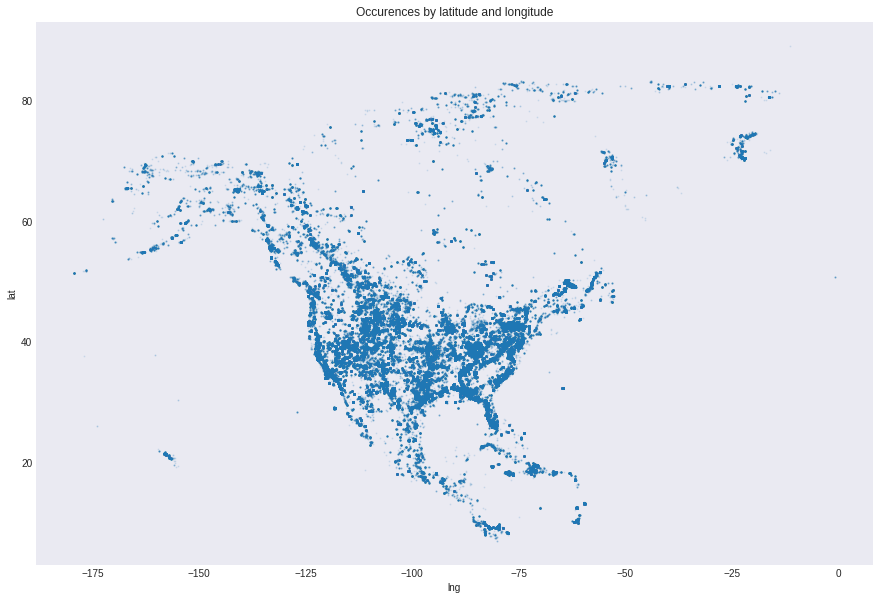

In [ ]:
print('-'*160)
print("This program allows users to learn more about the geology surrounding their location by exploring paleotological findings from the area.")
print()
print("Paleotontology involves the study of fossils, which are mineralized remains of living things. Fossils are found everywhere.")
print()
print("Here is a scatterplot plotting the latitude and longitude of various fossils found in North America.")
print('-'*160)
plt.style.use('seaborn-dark')
occs.loc[occs['lat']>0].loc[occs['lng']<0].plot(kind='scatter', x='lng', y='lat', title='Occurences by latitude and longitude', figsize=(15, 10), s=1, alpha=0.1)

In [ ]:
print('-'*160)
print("The program makes use of the Paleobiology Database, a database tracking millions of \"occurences\" of fossils referenced in research papers studying paleontology.", end='\n\n')
print("When a fossil is found as part of a study, information is collected about the fossil and the surrounding geological conditions. This information is represented" + '\n' + "as columns within a dataframe containing data imported from the Paleobiology Database, or PBDB.\n")
print("Each occurence represents a single species found at a site, and can contain multiple specimens.")
print('-'*160)
occs.sample(5)

----------------------------------------------------------------------------------------------------------------------------------------------------------------
The program makes use of the Paleobiology Database, a database tracking millions of "occurences" of fossils referenced in research papers studying paleontology.

When a fossil is found as part of a study, information is collected about the fossil and the surrounding geological conditions. This information is represented
as columns within a dataframe containing data imported from the Paleobiology Database, or PBDB.

Each occurence represents a single species found at a site, and can contain multiple specimens.
----------------------------------------------------------------------------------------------------------------------------------------------------------------


,occurrence_no,collection_no,identified_name,identified_rank,identified_no,difference,accepted_name,accepted_rank,accepted_no,early_interval,max_ma,min_ma,ref_author,ref_pubyr,reference_no,phylum,class,order,family,genus,image_no,abund_value,abund_unit,taxon_environment,environment_basis,motility,motility_basis,life_habit,life_habit_basis,vision,vision_basis,diet,diet_basis,ontogeny,ontogeny_basis,ecospace_comments,composition,architecture,thickness,reinforcement,taphonomy_basis,collection_name,collection_aka,lng,lat,cc,state,county,latlng_basis,latlng_precision,geogscale,geogcomments,paleomodel,paleolng,paleolat,geoplate,formation,stratgroup,member,formation.1,stratgroup.1,member.1,stratscale,zone,localsection,stratcomments,lithdescript,lithology1,lithadj1,lithification1,minor_lithology1,fossilsfrom1,lithology2,lithdescript.1,lithology1.1,lithadj1.1,lithification1.1,minor_lithology1.1,fossilsfrom1.1,environment,tectonic_setting,geology_comments,time_bins,time_contain,time_major,time_buffer,time_overlap,collection_type,collection_methods,museum,collection_coverage,collection_size,collection_comments,taxonomy_comments,created,modified,avg_ma,dis
205612,445943,43886,Fenestrellina sp.,genus,25556,NaN,Fenestrellina,genus,25556.0,Missourian,305.900,303.4000,Schneider,2003.0,11551,Bryozoa,Stenolaemata,Fenestrata,NO_FAMILY_SPECIFIED,Fenestrellina,171.0,14,grid-count,NaN,NaN,"stationary, attached",Stenolaemata,NaN,Fenestrata,blind,Stenolaemata,suspension feeder,Stenolaemata,NaN,NaN,NaN,low Mg calcite,NaN,NaN,NaN,Fenestrata,"Schneider, Brownwood Spillway: B 15","Winchell Formation, LS 2",-98.583336,31.500000,US,Texas,Brown,based on political unit,seconds,small collection,Lake Brownwood Spillway in north-central Texas.,gp_mid,-33.41,-6.69,101,Winchell,Canyon,NaN,Winchell,Canyon,NaN,group of beds,NaN,Brownwood Spillway,NaN,"LS 2: Massive, argillaceous, gray to light gre...",wackestone,"gray,green",lithified,argillaceous,Y,NaN,"LS 2: Massive, argillaceous, gray to light gre...",wackestone,"gray,green",lithified,argillaceous,Y,lagoonal/restricted shallow subtidal,NaN,NaN,Kasimovian,-,Kasimovian,"Kasimovian, Gzhelian","Kasimovian, Gzhelian",paleoecologic,field collection,NaN,NaN,NaN,NaN,NaN,2004-08-27 15:50:39,2004-08-27 17:50:39,304.65000,2101.185008
140337,237815,23713,Taeniocrada sp.,genus,263721,NaN,Taeniocrada,genus,263721.0,Givetian,387.700,382.7000,Schopf,1964.0,6755,NO_PHYLUM_SPECIFIED,NO_CLASS_SPECIFIED,NO_ORDER_SPECIFIED,NO_FAMILY_SPECIFIED,Taeniocrada,487.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Winslow Farm, Presque Isle",NaN,-68.016670,46.000000,US,Maine,NaN,based on political unit,minutes,NaN,"3 mi. west of Presque Isle, ME",gp_mid,-37.09,-28.65,101,Mapleton Sandstone,NaN,NaN,Mapleton Sandstone,NaN,NaN,formation,NaN,NaN,"This assemblage is younger than Trout Valley, ...",NaN,sandstone,NaN,NaN,silty,NaN,NaN,NaN,sandstone,NaN,NaN,silty,NaN,NaN,NaN,NaN,Givetian,Givetian,Givetian,Givetian,Givetian,taxonomic,NaN,NaN,NaN,NaN,NaN,NaN,2002-07-19 08:24:33,2002-07-19 10:24:33,385.20000,1088.006397
88289,143151,12386,Rhipidomella sp.,genus,26974,NaN,Rhipidomella,genus,26974.0,Asselian,298.900,295.5000,Mudge et al.,1962.0,4157,Brachiopoda,Rhynchonellata,Orthida,Rhipidomellidae,Rhipidomella,156.0,1,individuals,NaN,NaN,"stationary, attached",Orthida,NaN,Rhipidomella,blind,Rhynchonellata,suspension feeder,Orthida,NaN,NaN,BODY SIZE: Data from Williams et al (2002).,NaN,NaN,NaN,minor ribbing,Rhipidomella,"USGS Loc. 14804, Unit G, Neva LS member, Greno...",NaN,-96.631943,37.099998,US,Kansas,Cowley,based on political unit,minutes,outcrop,"NW1/4 SE1/4 sec. 11, T. 34S, R. 7E; coordinate...",gp_mid,-27.24,0.17,101,Grenola Limestone,Council Grove,Neva Limestone,Grenola Limestone,Council Grove,Neva Limestone,member,NaN,Unit G,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,marine indet.,NaN,NaN,Asselian,Asselian,Asselian,Asselian,Asselian,biostratigraphic,NaN,USGS,NaN,NaN,NaN,NaN,2001-11-04 09:59:28,2

----------------------------------------------------------------------------------------------------------------------------------------------------------------
This particular dataset includes data on 546979 occurences located in North America. The PBDB contains data on over 1.4 million occurences in total. This may 
seem like a lot, but the fossils you see here are not exactly the kind of fossil you may see in a museum.

A quick analysis of the different phylum (a classification rank) shows that Chordata, the phylum that mostly consists of vertebrates such as sharks and 
dinosaurs, makes up only 22% of all occurences.

A closer analysis of the different classes (a subset of phylums) shows that Reptilia, the class that dinosaurs fall under, make up just 3% of all occurences.
Although shark teeth are some of the most commonly owned fossils, they make up less than 1% of occurences under Chondrichthyes.  A majority of occurences
are classified as what most of us recognize as just "shells

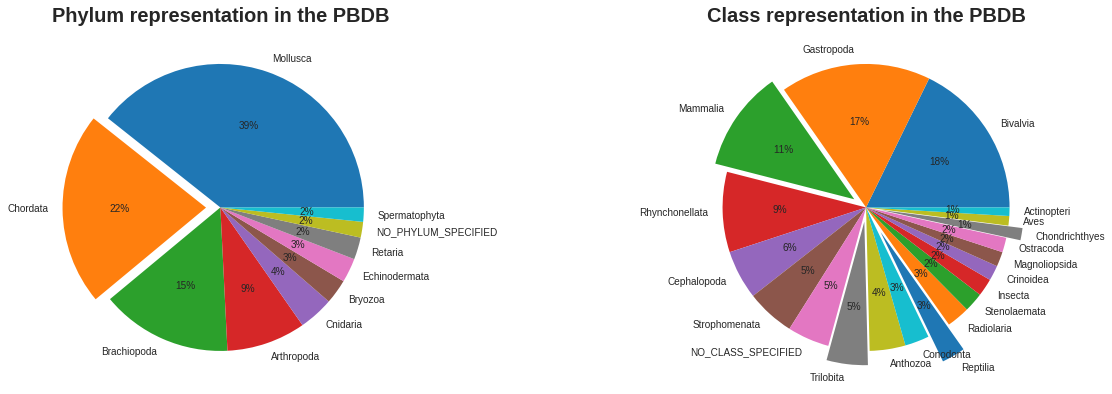

In [ ]:
print('-'*160)
print("This particular dataset includes data on " + str(len(occs)) + " occurences located in North America. The PBDB contains data on over 1.4 million occurences in total. This may " + '\n' + "seem like a lot, but the fossils you see here are not exactly the kind of fossil you may see in a museum.", end = '\n\n')
print("A quick analysis of the different phylum (a classification rank) shows that Chordata, the phylum that mostly consists of vertebrates such as sharks and " + '\n' + "dinosaurs, makes up only 22% of all occurences.", end = '\n\n')
print("A closer analysis of the different classes (a subset of phylums) shows that Reptilia, the class that dinosaurs fall under, make up just 3% of all occurences." + '\n' + "Although shark teeth are some of the most commonly owned fossils, they make up less than 1% of occurences under Chondrichthyes.  A majority of occurences" + '\n' + "are classified as what most of us recognize as just \"shells\".")
print('-'*160 + '\n')
occs_pie = occs['class'].value_counts()[:20].rename_axis('class').to_frame('count')
fig, ax = plt.subplots(1,2)
fig.set_figheight(10)
fig.set_figwidth(18)
fig.subplots_adjust(wspace=0.8)
explode1 = (0, 0.1, 0, 0, 0, 0, 0, 0, 0, 0)
explode2 = (0, 0, 0.1, 0, 0, 0, 0, 0.1, 0, 0, 0.2, 0, 0, 0, 0, 0, 0, 0.1, 0, 0)
ax[0].pie(occs['phylum'].value_counts()[:10].rename_axis('phylum').to_frame('count')['count'],labels=occs['phylum'].value_counts()[:10].rename_axis('phylum').to_frame('count').index, explode=explode1, autopct='%1.f%%')
ax[0].set_title('Phylum representation in the PBDB',size=20, fontweight = 'bold')
ax[1].pie(occs['class'].value_counts()[:20].rename_axis('class').to_frame('count')['count'],labels=occs['class'].value_counts()[:20].rename_axis('class').to_frame('count').index, explode=explode2, autopct='%1.f%%')
ax[1].set_title('Class representation in the PBDB',size=20, fontweight = 'bold')
fig.show()

In [ ]:
print('-'*160)
print("Additionally, even fossils that would be recognizeable by name may not be recognizeable as an occurence. This map of T-rex occurences shows",len(filter(occs, 'accepted_name', 'tyrannosaurus')), "total occurences. \nAre T-rexes that common?", end = '\n\n')
print("This is because a vast majority of vertebrate fossils are found incomplete. Just a single tooth or chunk of bone would still count as anoccurence as long as it" + '\n' + "is identifiable as T-rex with reasonable confidence. Considering T-rexes existed for 2 million years and regularly regenerated teeth, it makes sense that T-rex" + '\n' + "fossils are found relatively often.\n")
print("On the other hand, only a small percentage of fossils found end up in a paper and in the PBDB. Finds made by amateur collectors make up a majority of total \nfinds for many species, but almost never get recognized as an occurence in the PBDB.")
print('-'*160)
heatmap(filter(occs, 'accepted_name', 'tyrannosaurus'), 'accepted_name', ['occurrence_no', 'formation.1', 'min_ma'], 6, 'Tyrannosaurus Rex Occurences').show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------
Additionally, even fossils that would be recognizeable by name may not be recognizeable as an occurence. This map of T-rex occurences shows 79 total occurences. 
Are T-rexes that common?

This is because a vast majority of vertebrate fossils are found incomplete. Just a single tooth or chunk of bone would still count as anoccurence as long as it
is identifiable as T-rex with reasonable confidence. Considering T-rexes existed for 2 million years and regularly regenerated teeth, it makes sense that T-rex
fossils are found relatively often.

On the other hand, only a small percentage of fossils found end up in a paper and in the PBDB. Finds made by amateur collectors make up a majority of total 
finds for many species, but almost never get recognized as an occurence in the PBDB.
----------------------------------------------------

#### Location-Specific Analysis

In [ ]:
# tell user about what you can find around your area

local = {
    'lat': float(input("Enter Latitude: ")),
    'prx': float(input("Enter Search Radius (km): "))
}

if local['lat'] == 0:
  local['lat'], local['lng'] = 38.954503, -77.247611
elif local['lat'] == 1:
  local['lat'], local['lng'] = 40.729009, -73.995959
elif local['lat'] == 2:
  local['lat'], local['lng']= 43.058888, -76.031289
else:
  local['lng'] = float(input("Enter Longitude: "))

proximity = distances(occs, local['lat'], local['lng'], local['prx'])

print('-'*120)
print('Search Report Summary')
print('The search returned ' + str(len(proximity)) + ' occurences within ' + str(local['prx']) + ' kilometers of ' + str(local['lat']) + ', ' + str(local['lng']) + '.')
usa_occ_score, y_occ_score = round(100*409217/3797000,2), round(100*len(proximity)/spherical_sector_area(local['prx']),2)
print('Your search radius contains ' + str(y_occ_score) + ' occurences per square km, which is ' + str(abs(round(100*y_occ_score / usa_occ_score) - 100)) + "% " + ('higher' if 100*y_occ_score / usa_occ_score > 100 else 'lower') + ' than the national average of ' + str(usa_occ_score) + '.')
print('The average age of occurences within your search is',round(proximity['avg_ma'].mean(),2), 'million years.')
print('-'*120)
heatmap(proximity, 'accepted_name', ['occurrence_no', 'formation.1', 'min_ma'], 6, 'Nearby Fossil Occurences').show()

Enter Latitude: 0
Enter Search Radius (km): 100
------------------------------------------------------------------------------------------------------------------------
Search Report Summary
The search returned 5084 occurences within 100.0 kilometers of 38.954503, -77.247611.
Your search radius contains 16.18 occurences per square km, which is 50% higher than the national average of 10.78.
The average age of occurences within your search is 89.09 million years.
------------------------------------------------------------------------------------------------------------------------


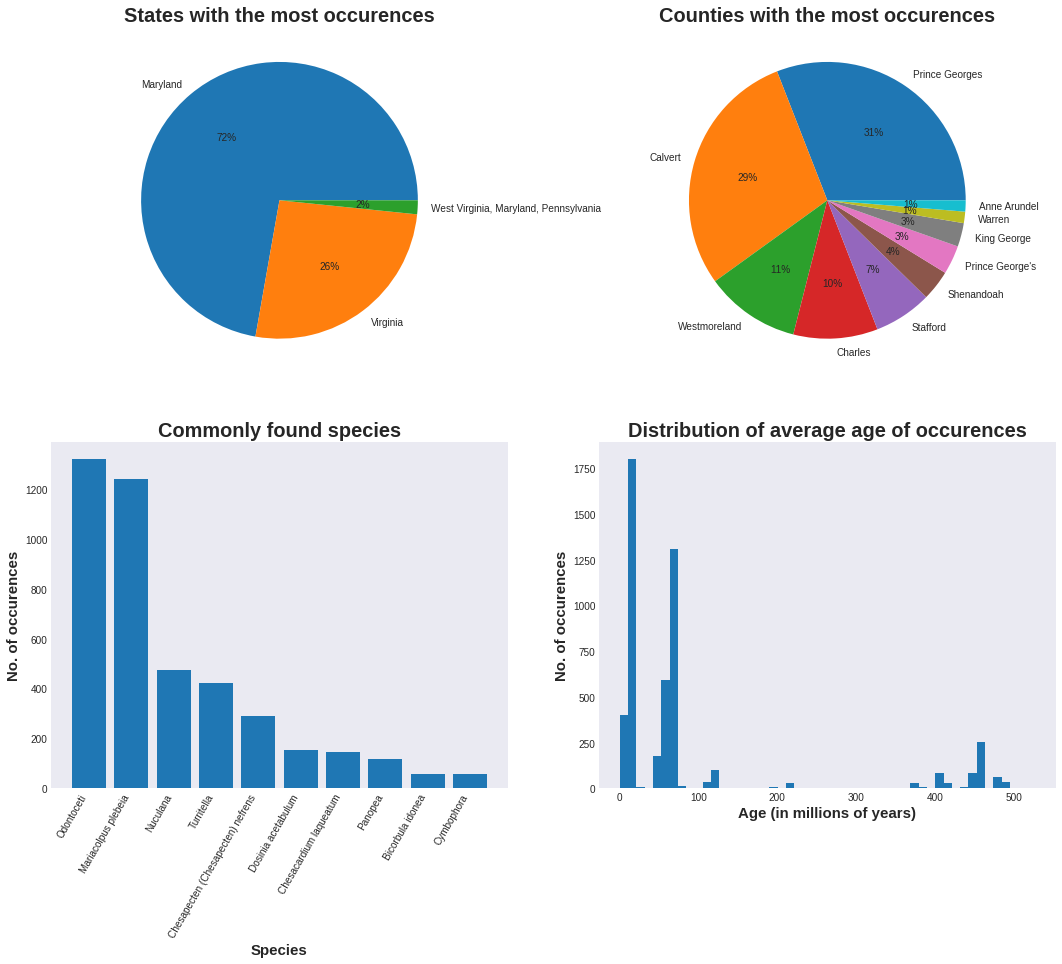

In [ ]:
fig, ax = plt.subplots(2,2)
fig.set_figheight(14)
fig.set_figwidth(18)
fig.subplots_adjust(wspace=0.2)
ax[0,0].pie(proximity['state'].value_counts()[:3].rename_axis('state').to_frame('count')['count'],labels=proximity['state'].value_counts()[:3].rename_axis('state').to_frame('count').index, autopct='%1.f%%')
ax[0,0].set_title('States with the most occurences',size=20, fontweight = 'bold')
ax[0,1].pie(proximity['county'].value_counts()[:10].rename_axis('county').to_frame('count')['count'],labels=proximity['county'].value_counts()[:10].rename_axis('county').to_frame('count').index, autopct='%1.f%%')
ax[0,1].set_title('Counties with the most occurences',size=20, fontweight = 'bold')
ax[1,0].bar(proximity['accepted_name'].value_counts()[:10].rename_axis('accepted_name').to_frame('count').index, height=proximity['county'].value_counts()[:10].rename_axis('accepted_name').to_frame('count')['count'],)
ax[1,0].set_title('Commonly found species',size=20, fontweight = 'bold')
ax[1,0].set_xticklabels(proximity['accepted_name'].value_counts()[:10].rename_axis('accepted_name').to_frame('count').index, Rotation='60', ha="right")
ax[1,0].set_xlabel("Species",size=15, fontweight = 'bold')
ax[1,0].set_ylabel("No. of occurences",size=15, fontweight = 'bold')
ax[1,1].hist(proximity['avg_ma'],bins=50)
ax[1,1].set_title('Distribution of average age of occurences',size=20, fontweight = 'bold')
ax[1,1].set_xlabel("Age (in millions of years)",size=15, fontweight = 'bold')
ax[1,1].set_ylabel("No. of occurences",size=15, fontweight = 'bold')
fig.show()

In [ ]:
# group, formation, member
group_age = proximity.groupby('stratgroup.1')['avg_ma'].mean().sort_values()
formation_age = proximity.groupby('formation.1')['avg_ma'].mean().sort_values()
member_age = proximity.groupby('member.1')['avg_ma'].mean().sort_values()
gmf = proximity.groupby(['stratgroup.1', 'formation.1','member.1','avg_ma']).mean()
gmf.drop(gmf.columns.difference(['lng','lat']), 1, inplace=True)
gmf_r = gmf.reset_index()
heatmap(gmf_r, 'member.1',['avg_ma','formation.1','stratgroup.1'],10,'Estimated Location of Members, Formations, and Groups').show()
gmf

lng  \
stratgroup.1 formation.1        member.1           avg_ma                
Chatham      Bull Run           Balls Bluff        218.2500 -77.481913   
                                Groveton           216.7500 -77.915054   
             Manassas Sandstone Poolesville        218.2500 -77.455517   
Chesapeake   Calvert            Boston Cliffs      12.7200  -76.461945   
                                Calvert Beach      12.7200  -76.513611   
                                                   13.7890  -76.966942   
                                                   14.8950  -76.710510   
                                Conoy              12.7200  -76.461945   
                                Drumcliff          12.7200  -76.471466   
                                Fairhaven          18.2050  -76.782070   
                                Little Cove Point  9.4330   -76.461945   
                                Plum Point         12.7200  -76.500000   
                                                   13.7890  -76.522408   
                                                   14.8950  -76.686371   
                                                   18.2050  -76.522915   
                                Plum Point Marl    13.7890  -76.525722   
                                Popes Creek Sand   18.2050  -76.726461   
             Choptank           Boston Cliffs      12.7200  -76.551573   
                                                   13.7890  -76.505445   
                                Conoy              12.7200  -76.478615   
                                Drumcliff          12.7200  -76.508268   
                                                   13.7890  -76.491818   
                                St. Leonard        12.7200  -76.482498   
             Eastover           Claremont Manor    6.2895   -76.831112   
             St Mary's          Little Cove Point  8.4705   -76.387497   
             St Marys           Little Cove Point  9.4330   -76.387497   
Pamunkey     Aquia              Paspotansa         57.2500  -77.272084   
                                Piscataway         57.2500  -77.299446   
                                                   57.6000  -77.010399   
             Nanjemoy           Potapaco           52.2000  -77.265160   
                                Woodstock          44.5500  -76.991669   
                                                   51.9000  -77.015278   
Wilcox       Tuscahoma          Bells Landing Marl 57.6000  -76.548889   

                                                                   lat  
stratgroup.1 formation.1        member.1           avg_ma               
Chatham      Bull Run           Balls Bluff        218.2500  38.883427  
                                Groveton           216.7500  38.439735  
             Manassas Sandstone Poolesville        218.2500  38.778140  
Chesapeake   Calvert            Boston Cliffs      12.7200   38.450279  
                                Calvert Beach      12.7200   38.517502  
                                                   13.7890   38.180279  
                                                   14.8950   38.473481  
                                Conoy              12.7200   38.450279  
                                Drumcliff          12.7200   38.461135  
                                Fairhaven          18.2050   38.633863  
                                Little Cove Point  9.4330    38.450279  
                                Plum Point         12.7200   38.400002  
                                                   13.7890   38.638704  
                                                   14.8950   38.373145  
                                                   18.2050   38.627697  
                                Plum Point Marl    13.7890   38.645944  
                                Popes Creek Sand   18.2050   38.700186  
             Choptank           Boston Cliffs      12.7200   38.411286  
                

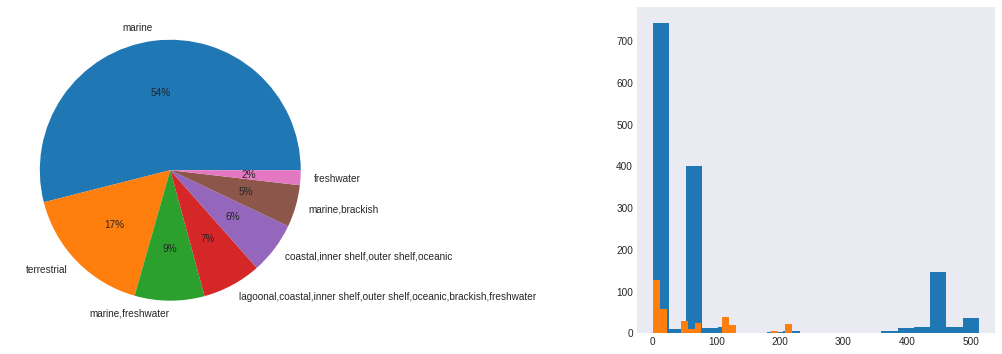

In [ ]:
fig, ax = plt.subplots(1,2)
fig.set_figheight(6)
fig.set_figwidth(18)
fig.subplots_adjust(wspace=0.8)
taxon_ages = proximity[['taxon_environment', 'avg_ma']].dropna()
ax[0].pie(proximity['taxon_environment'].value_counts()[:7].rename_axis('taxon_environment').to_frame('count')['count'],labels=proximity['taxon_environment'].value_counts()[:7].rename_axis('taxon_environment').to_frame('count').index, autopct='%1.f%%')
ax[1].hist(taxon_ages.loc[taxon_ages['taxon_environment'].str.contains('marine', na=False)]['avg_ma'], bins=20)
ax[1].hist(taxon_ages.loc[taxon_ages['taxon_environment'].str.contains('terr', na=False)]['avg_ma'], bins=20)
fig.show()

In [ ]:
# track paleological location over time
paleoprx = distances(occs, local['lat'], local['lng'], local['prx'] if input("Scale up search radius to increase accuracy? (Y/N) ") == 'N' else 300)
paleoloc = paleoprx[['avg_ma','paleolat','paleolng']]
paleoloc['avg_ma'] = paleoloc['avg_ma'].round(0)
empty = pd.DataFrame(index=np.arange(528), columns=np.arange(0))
empty.reset_index(inplace=True)
empty.rename(columns={'index': "avg_ma"}, inplace=True)
locs = pd.merge(paleoloc.groupby('avg_ma')['paleolat'].mean().sort_values(), paleoloc.groupby('avg_ma')['paleolng'].mean().sort_values(), how='inner', on='avg_ma')
paleoloc_ = pd.merge(empty, locs, how='left', on='avg_ma')
paleoloc_.sort_values('avg_ma',inplace=True)
paleoloc_['paleolat'] = paleoloc_['paleolat'].interpolate(method='spline', order=2)
paleoloc_['paleolng'] = paleoloc_['paleolng'].interpolate(method='spline', order=2)
heatmap(paleoloc_.rename(columns={'paleolat': "lat", 'paleolng': "lng"}), 'avg_ma', ['lat', 'lng'], 10, 'Track Your Geology Over Time').show()

Scale up search radius to increase accuracy? (Y/N) Y


#### Tests
---


Actual interpolation


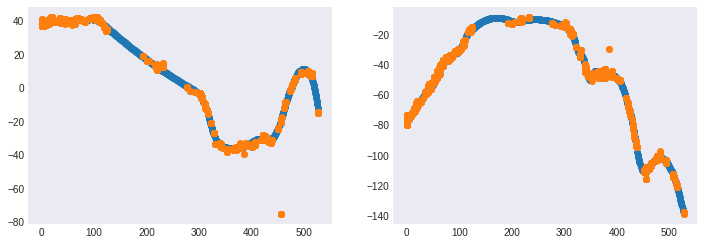

In [ ]:
# Tests
print("Actual interpolation")
fig, ax = plt.subplots(1,2)
fig.set_figheight(4)
fig.set_figwidth(12)
ax[0].scatter(paleoloc_['avg_ma'], paleoloc_['paleolat'])
ax[0].scatter(paleoloc['avg_ma'], paleoloc['paleolat'])
ax[1].scatter(paleoloc_['avg_ma'], paleoloc_['paleolng'])
ax[1].scatter(paleoloc['avg_ma'], paleoloc['paleolng'])
fig.show()

In [ ]:
# Heatmap using data before interpolation
heatmap(paleoloc.rename(columns={'paleolat': "lat", 'paleolng': "lng"}), 'avg_ma', ['lat', 'lng'], 10, 'Track Your Geology Over Time').show()

## Occurence Search Tools

### Search by species


In [ ]:
heatmap(filter(occs, 'accepted_name', input('Enter specimen name: ')), 'accepted_name', ['occurrence_no', 'formation.1', 'min_ma'], 6, 'Specimens Map').show()

Enter specimen name: trilobit


### Search by state

In [ ]:
heatmap(filter(occs, 'state', input('Enter state: ')), 'state', ['occurrence_no', 'formation.1', 'min_ma'], 6, 'Specimens Map').show()

Enter state: New York


### Search by county

### Visualizations

In [ ]:
import requests
import io
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from math import radians, cos, sin, asin, sqrt
pd.options.mode.chained_assignment = None


In [ ]:
states = occs.loc[occs['cc'] == 'US']
states = states.groupby(['state'])['max_ma'].mean()
#We would like to see what states the oldest fossils would be located and where the youngest are
#This could give us insights into the previous environments of the current states
states = pd.DataFrame(states)
states = states.sort_values(by='max_ma',ascending=False)
states = states.reset_index()
states = states[states.state != ('Califormia','Flrida','Sussex','Michiagn','florida','Unknown','')]
states = states.sort_values(by = 'max_ma',ascending = False)
states = states.set_index('state')

Text(0.5, 0, 'Average Age of Fossils in Millions')

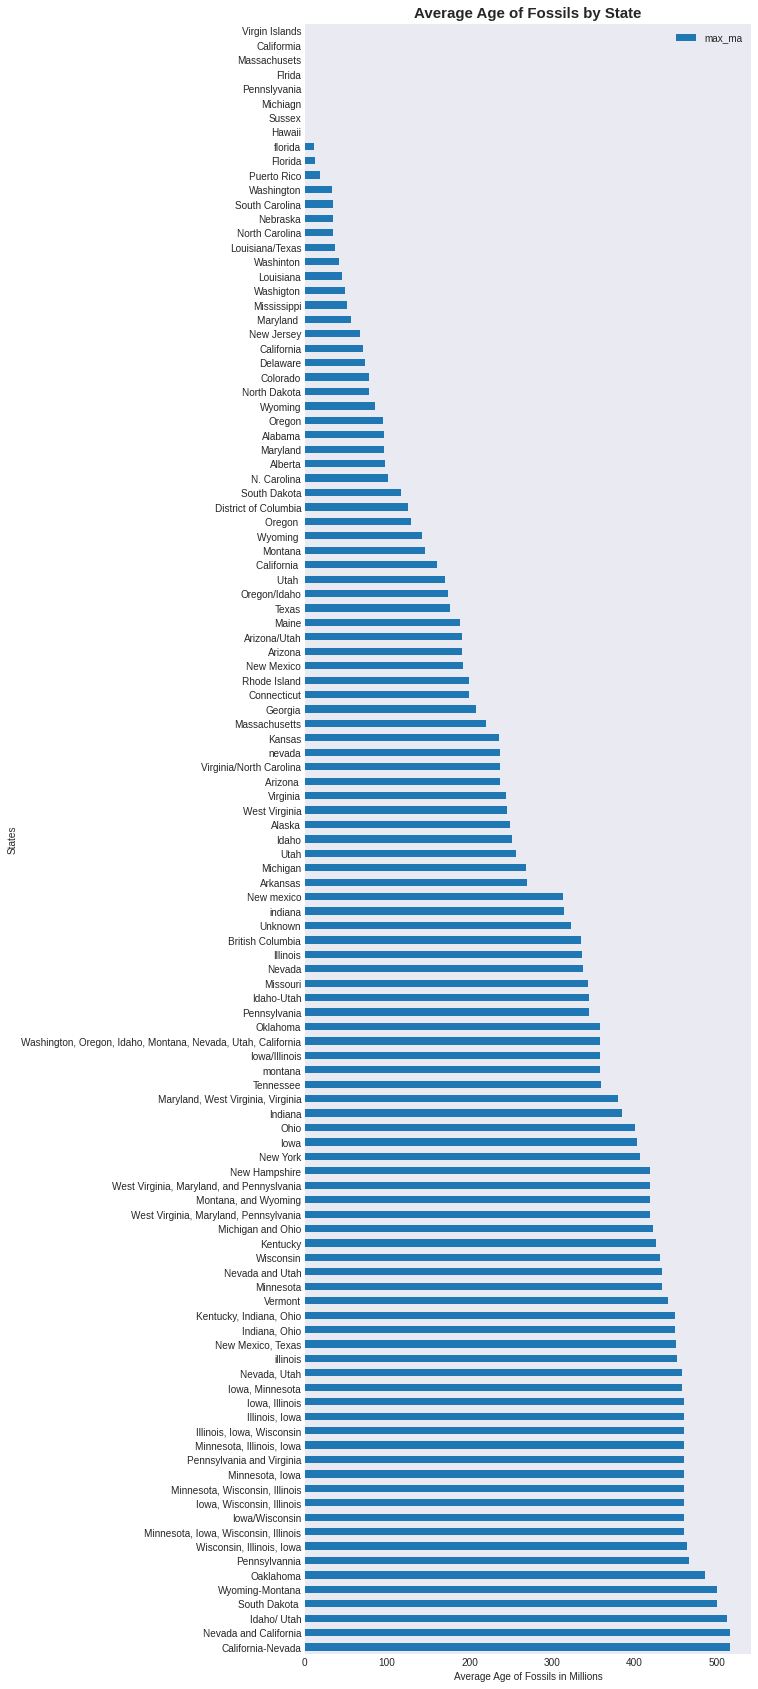

In [ ]:
fig, ax = plt.subplots()
states.plot.barh(figsize = (8,30), ax=ax)
ax.set_title('Average Age of Fossils by State',size=15, fontweight = 'bold')
ax.set_ylabel('States')
ax.set_xlabel('Average Age of Fossils in Millions')

In [ ]:
rank = occs.groupby('identified_rank')['max_ma'].mean()
rank = pd.DataFrame(rank)
rank = rank.reset_index()
rank = rank.loc[(rank['identified_rank']).isin(['kingdom','phylum','class','order','family','genus','species'])]
rank = rank.reindex([6,8,0,7,1,2,9])
rank


,identified_rank,max_ma
6,kingdom,166.153996
8,phylum,318.027774
0,class,288.973864
7,order,258.718479
1,family,102.719258
2,genus,230.715823
9,species,187.043246


Text(0.5, 0, 'Average Age of Fossils in Millions for Each Respective Rank')

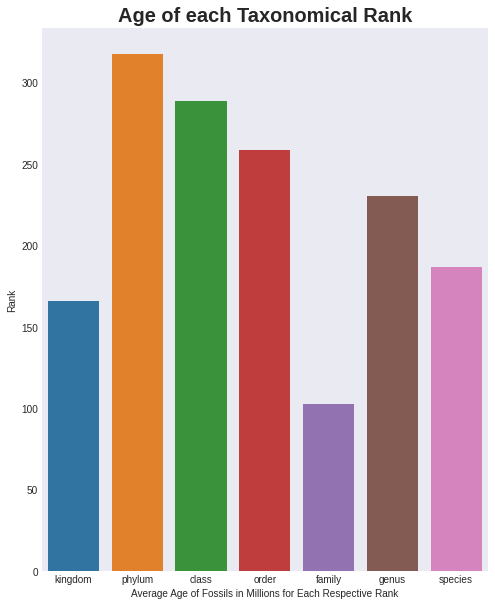

In [ ]:
fig = plt.figure(figsize=(8,10))               
sns.barplot(x='identified_rank', y= 'max_ma', data=rank) 
plt.title('Age of each Taxonomical Rank',fontsize=20,fontweight= 'bold')
plt.ylabel('Rank')
plt.xlabel('Average Age of Fossils in Millions for Each Respective Rank')